In [163]:
import sqlite3
import numpy as np
import pandas as pd
from pandas import DataFrame
from sklearn import tree

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


In [164]:
# Open the testing database
con = sqlite3.connect("test.db")
c = con.cursor()

In [165]:
# Check to see if the database and tables exists
c.execute("""SELECT * FROM game_table LIMIT 5""")
con.commit()

res = c.fetchall()
print(res)

[(3736851, 'koth_product_final', 1123, 3, 0, 3, 0, 'Blu'), (3736847, 'cp_gullywash_f9', 702, 5, 0, 5, 0, 'Blu'), (3736843, 'cp_process_final12', 1553, 2, 1, 1, 2, 'Red'), (3736841, 'cp_process_f12', 1759, 1, 4, 0, 5, 'Red'), (3736830, 'cp_metalworks', 1749, 4, 1, 4, 2, 'Blu')]


In [166]:
# Initialize gameID and count for sampling 200 random games
game = 3736855
count = 0
viable = []

while count < 200:
    random_int = np.random.randint(0, 20001)
    new_game_id = str(game - random_int)

    c.execute("""SELECT * FROM game_table
                WHERE game_ID LIKE ?""", (new_game_id,))
    con.commit()
    res = c.fetchall()

    # If the game is within the game_table, then append the id to viable[]
    if(len(res) > 0):
        viable.append(new_game_id)
        count += 1

In [167]:
# We can now take 80% of those game and use that to train for classification
np.random.shuffle(viable)
train = viable[:160]
test = viable[160:]

In [168]:
# Query the training set
query = f"SELECT * FROM game_table WHERE game_ID IN ({', '.join('?' for _ in train)})"
c.execute(query, train)
con.commit()
res = c.fetchall()

train_df = DataFrame(res)
train_df.columns = ['game_ID','type','time','blu_firstcaps','red_firstcaps','blu_score','red_score','winner']

# Fetch round data and sum total dmg
query = f"SELECT game_ID, SUM(blu_dmg), SUM(red_dmg), SUM(blu_ubers), SUM(red_ubers) FROM game_round WHERE game_ID IN ({', '.join('?' for _ in train)}) GROUP BY game_ID"
c.execute(query, train)
con.commit()

res = c.fetchall()
temp_df = DataFrame(res)
temp_df.columns = ['game_ID', 'blu_dmg', 'red_dmg', 'blu_ubers', 'red_ubers']

# Merge dataframes on game_ID
train_df = pd.merge(train_df, temp_df, on='game_ID', how='left')
train_df.head(5)

,game_ID,type,time,blu_firstcaps,red_firstcaps,blu_score,red_score,winner,blu_dmg,red_dmg,blu_ubers,red_ubers
0,3717057,koth_ashville_final1,1331,2,2,3,1,Blu,62490,58696,8,10
1,3717202,koth_product_final,1050,2,1,3,0,Blu,53214,42979,11,5
2,3717203,cp_process_f12,312,0,1,1,0,Blu,7001,5674,2,3
3,3717274,koth_product_final,803,0,3,0,3,Red,27063,36994,4,6
4,3717365,cp_snakewater_final1,1769,2,2,4,0,Blu,36213,31100,5,10


In [169]:
# Convert string values into numerical values using dictionaries
map_dict = {'cp' : 0, 'koth' : 1}
winner_dict = {'Blu' : 0, 'Red' : 1, 'Tie' : 2}

train_df['type'] = train_df['type'].str.split('_').str[0]
train_df['type'] = train_df['type'].map(map_dict)
train_df['winner'] = train_df['winner'].map(winner_dict)

# We want to look at a game as either a win or not a win
# We also want to look at this in terms of either one side, so we should conver 'winner' and both 'blu_dmg','red_dmg' in binomial terms
train_df['more_dmg'] = (train_df['blu_dmg'] > train_df['red_dmg']).astype(int)
train_df['more_ubers'] = (train_df['blu_ubers'] > train_df['red_ubers']).astype(int)
train_df['win_blu'] = (train_df['winner'] < 1).astype(int)
train_df['win_red'] = (train_df['winner'] == 1).astype(int)

# Create a copy of the dataframe and drop columns
train_df_blu = train_df.copy()
train_df_blu = train_df_blu.drop(columns = ['game_ID','time','red_firstcaps','blu_score','red_score','winner','red_dmg','red_ubers','win_red'])

train_df_red = train_df.copy()
train_df_red = train_df_red.drop(columns = ['game_ID','time','blu_firstcaps','blu_score','red_score','winner','blu_dmg','blu_ubers','win_blu'])
train_df.head(5)

,game_ID,type,time,blu_firstcaps,red_firstcaps,blu_score,red_score,winner,blu_dmg,red_dmg,blu_ubers,red_ubers,more_dmg,more_ubers,win_blu,win_red
0,3717057,1,1331,2,2,3,1,0,62490,58696,8,10,1,0,1,0
1,3717202,1,1050,2,1,3,0,0,53214,42979,11,5,1,1,1,0
2,3717203,0,312,0,1,1,0,0,7001,5674,2,3,1,0,1,0
3,3717274,1,803,0,3,0,3,1,27063,36994,4,6,0,0,0,1
4,3717365,0,1769,2,2,4,0,0,36213,31100,5,10,1,0,1,0


In [170]:
# X for features, y for target column
features_blu = ['type','blu_firstcaps','blu_dmg','blu_ubers','more_dmg','more_ubers']
features_red = ['type','red_firstcaps','red_dmg','red_ubers','more_dmg','more_ubers']

Xb = train_df_blu[features_blu]
Xr = train_df_red[features_red]

yb = train_df_blu['win_blu']
yr = train_df_red['win_red']


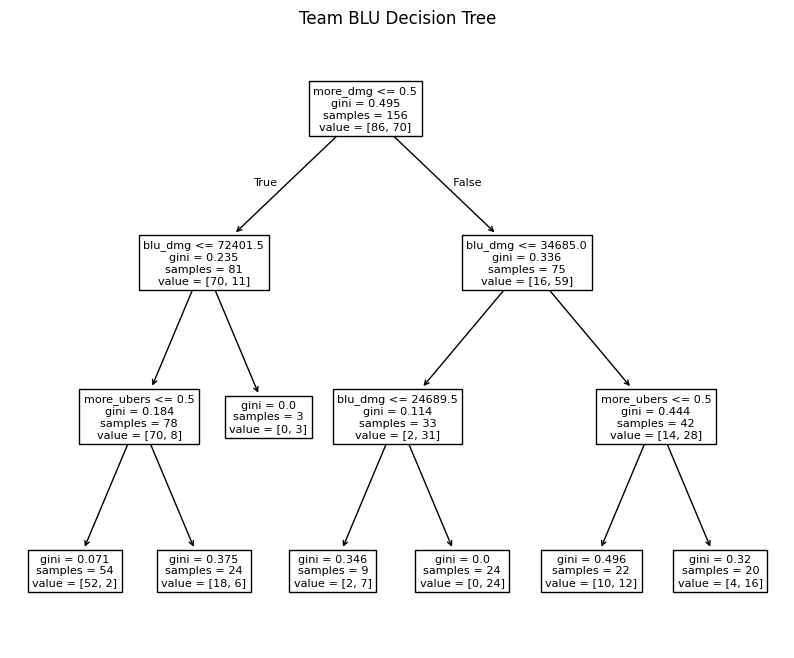

In [171]:
# Create decision trees
dtree = DecisionTreeClassifier(max_depth = 3)
dtree = dtree.fit(Xb,yb)

plt.figure(figsize = (10, 8))
tree.plot_tree(dtree, feature_names = features_blu)
plt.title("Team BLU Decision Tree")
plt.show()

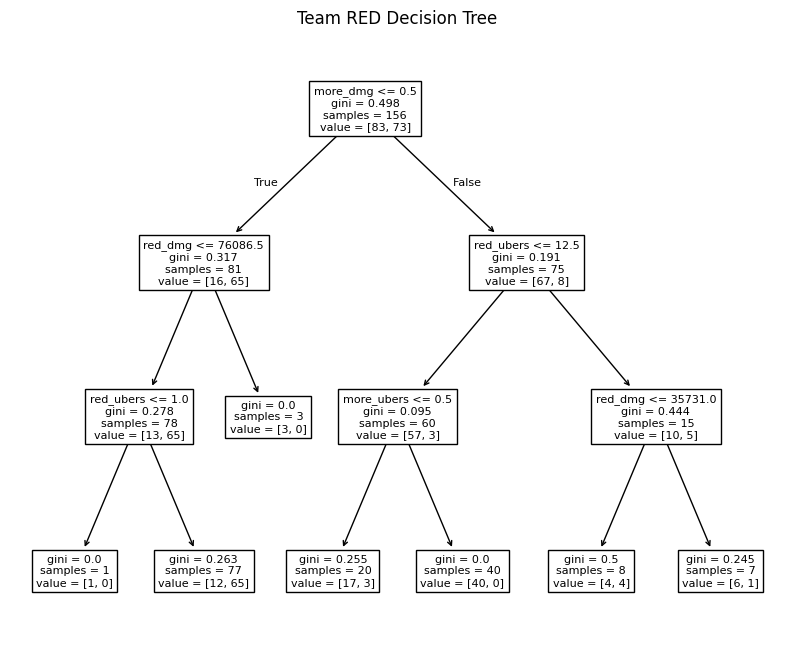

In [172]:
# Create decision trees
dtree = DecisionTreeClassifier(max_depth = 3)
dtree = dtree.fit(Xr,yr)

plt.figure(figsize = (10, 8))
tree.plot_tree(dtree, feature_names = features_red)
plt.title("Team RED Decision Tree")
plt.show()

In [173]:
# Query the test set
query = f"SELECT * FROM game_table WHERE game_ID IN ({', '.join('?' for _ in test)})"
c.execute(query, test)
con.commit()
res = c.fetchall()

test_df = DataFrame(res)
test_df.columns = ['game_ID','type','time','blu_firstcaps','red_firstcaps','blu_score','red_score','winner']

# Fetch round data and sum total dmg
query = f"SELECT game_ID, SUM(blu_dmg), SUM(red_dmg), SUM(blu_ubers), SUM(red_ubers) FROM game_round WHERE game_ID IN ({', '.join('?' for _ in test)}) GROUP BY game_ID"
c.execute(query, test)
con.commit()

res = c.fetchall()
temp_df = DataFrame(res)
temp_df.columns = ['game_ID', 'blu_dmg', 'red_dmg', 'blu_ubers', 'red_ubers']

# Merge dataframes on game_ID
test_df = pd.merge(test_df, temp_df, on='game_ID', how='left')
test_df.head(5)

,game_ID,type,time,blu_firstcaps,red_firstcaps,blu_score,red_score,winner,blu_dmg,red_dmg,blu_ubers,red_ubers
0,3716935,cp_sunshine,1534,1,2,3,0,Blu,33491,30879,10,12
1,3717371,cp_snakewater_final1,1329,2,3,0,5,Red,28791,31662,9,11
2,3717679,cp_gullywash_f9,1317,2,4,4,2,Blu,27708,23314,10,7
3,3718283,cp_process_f12,1759,3,2,1,4,Red,35371,36737,13,12
4,3718372,cp_gullywash_final1,1750,2,4,1,5,Red,40305,42303,9,13


In [174]:
# Convert string values into numerical values using dictionaries
map_dict = {'cp' : 0, 'koth' : 1}
winner_dict = {'Blu' : 0, 'Red' : 1, 'Tie' : 2}

test_df['type'] = test_df['type'].str.split('_').str[0]
test_df['type'] = test_df['type'].map(map_dict)
test_df['winner'] = test_df['winner'].map(winner_dict)

# We want to look at a game as either a win or not a win
# We also want to look at this in terms of either one side, so we should conver 'winner' and both 'blu_dmg','red_dmg' in binomial terms
test_df['more_dmg'] = (test_df['blu_dmg'] > test_df['red_dmg']).astype(int)
test_df['more_ubers'] = (test_df['blu_ubers'] > test_df['red_ubers']).astype(int)
test_df['win_blu'] = (test_df['winner'] < 1).astype(int)
test_df['win_red'] = (test_df['winner'] == 1).astype(int)

# Create a copy of the dataframe and drop columns
test_df_blu = test_df.copy()
test_df_blu = test_df_blu.drop(columns = ['game_ID','time','red_firstcaps','blu_score','red_score','winner','red_dmg','red_ubers','win_red'])

test_df_red = test_df.copy()
test_df_red = test_df_red.drop(columns = ['game_ID','time','blu_firstcaps','blu_score','red_score','winner','blu_dmg','blu_ubers','win_blu'])

In [175]:
# Test the training set against the test set
# Arr = [TP,FP,FN,TN]

# Blu decision tree
dtree = DecisionTreeClassifier(max_depth = 3)
dtree = dtree.fit(Xb,yb)
blu_confusion_matrix = [0,0,0,0]

for i in range(test_df_blu.shape[0]):
    test_row = test_df_blu.iloc[i, :-1].tolist()
    real = int(test_df_blu.iloc[i, -1:])
    estimate = dtree.predict([test_row])[0]
    
    if(estimate == real):
        blu_confusion_matrix[0] += 1
    elif(estimate == 1 and real == 0):
        blu_confusion_matrix[1] += 1
    elif(estimate == 0 and real == 1):
        blu_confusion_matrix[2] += 1
    else:
        blu_confusion_matrix[3] += 1


# Red decision tree
dtree = DecisionTreeClassifier(max_depth = 3)
dtree = dtree.fit(Xr,yr)
red_confusion_matrix = [0,0,0,0]

for i in range(test_df_red.shape[0]):
    test_row = test_df_red.iloc[i, :-1].tolist()
    real = int(test_df_red.iloc[i, -1:])
    estimate = dtree.predict([test_row])[0]
    
    if(estimate == real):
        red_confusion_matrix[0] += 1
    elif(estimate == 1 and real == 0):
        red_confusion_matrix[1] += 1
    elif(estimate == 0 and real == 1):
        red_confusion_matrix[2] += 1
    else:
        red_confusion_matrix[3] += 1

C:\Users\Bobby\AppData\Local\Temp\ipykernel_17880\1367488513.py:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real = int(test_df_blu.iloc[i, -1:])
c:\Users\Bobby\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Bobby\AppData\Local\Temp\ipykernel_17880\1367488513.py:11: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real = int(test_df_blu.iloc[i, -1:])
c:\Users\Bobby\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\Bobby\AppData\Local\Temp\ipykernel_17

In [176]:
# Arr = [TP,FP,FN,TN]
# Generally looking for accuracy between 70% and 90%
print("Blu Decision Tree:: Recall: " + str(blu_confusion_matrix[0]/(blu_confusion_matrix[0] + blu_confusion_matrix[2])) 
      + ", Precision: " + str(blu_confusion_matrix[0]/(blu_confusion_matrix[0]+blu_confusion_matrix[1])) 
      + ", Accuracy: " + str((blu_confusion_matrix[0]+blu_confusion_matrix[3])/sum(blu_confusion_matrix)))

print("Red Decision Tree:: Recall: " + str(red_confusion_matrix[0]/(red_confusion_matrix[0] + red_confusion_matrix[2])) 
      + ", Precision: " + str(red_confusion_matrix[0]/(red_confusion_matrix[0]+red_confusion_matrix[1])) 
      + ", Accuracy: " + str((red_confusion_matrix[0]+red_confusion_matrix[3])/sum(red_confusion_matrix)))

Blu Decision Tree:: Recall: 0.9411764705882353, Precision: 0.8648648648648649, Accuracy: 0.8205128205128205
Red Decision Tree:: Recall: 0.9166666666666666, Precision: 0.9166666666666666, Accuracy: 0.8461538461538461


In [177]:
# Seperate training/testing data into features
Xb = train_df_blu.drop('win_blu', axis = 1)
yb = train_df_blu['win_blu']
Xb_test = test_df_blu.drop('win_blu', axis = 1)

Xr = train_df_red.drop('win_red', axis = 1)
yr = train_df_red['win_red']
Xr_test = test_df_red.drop('win_red', axis = 1)

In [178]:
# Use Naive Bayes to classify the training set and apply to test set
# Arr = [TP,FP,FN,TN]
model = GaussianNB()
model.fit(Xb, yb)
blu_estimate = model.predict(Xb_test)
blu_confusion_matrix = [0,0,0,0]

for i in range(len(blu_estimate)):
    real = int(test_df_blu.iloc[i, -1:])
    estimate = blu_estimate[i]

    if(estimate == real):
        blu_confusion_matrix[0] += 1
    elif(estimate == 1 and real == 0):
        blu_confusion_matrix[1] += 1
    elif(estimate == 0 and real == 1):
        blu_confusion_matrix[2] += 1
    else:
        blu_confusion_matrix[3] += 1

model = GaussianNB()
model.fit(Xr, yr)
red_estimate = model.predict(Xr_test)
red_confusion_matrix = [0,0,0,0]

for i in range(len(red_estimate)):
    real = int(test_df_red.iloc[i, -1:])
    estimate = red_estimate[i]

    if(estimate == real):
        red_confusion_matrix[0] += 1
    elif(estimate == 1 and real == 0):
        red_confusion_matrix[1] += 1
    elif(estimate == 0 and real == 1):
        red_confusion_matrix[2] += 1
    else:
        red_confusion_matrix[3] += 1

C:\Users\Bobby\AppData\Local\Temp\ipykernel_17880\2908344721.py:9: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real = int(test_df_blu.iloc[i, -1:])
C:\Users\Bobby\AppData\Local\Temp\ipykernel_17880\2908344721.py:27: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  real = int(test_df_red.iloc[i, -1:])


In [179]:
# Arr = [TP,FP,FN,TN]
# Generally looking for accuracy between 70% and 90%
print("Blu Naive Bayes:: Recall: " + str(blu_confusion_matrix[0]/(blu_confusion_matrix[0] + blu_confusion_matrix[2])) 
      + ", Precision: " + str(blu_confusion_matrix[0]/(blu_confusion_matrix[0]+blu_confusion_matrix[1])) 
      + ", Accuracy: " + str((blu_confusion_matrix[0]+blu_confusion_matrix[3])/sum(blu_confusion_matrix)))

print("Red Naive Bayes:: Recall: " + str(red_confusion_matrix[0]/(red_confusion_matrix[0] + red_confusion_matrix[2])) 
      + ", Precision: " + str(red_confusion_matrix[0]/(red_confusion_matrix[0]+red_confusion_matrix[1])) 
      + ", Accuracy: " + str((red_confusion_matrix[0]+red_confusion_matrix[3])/sum(red_confusion_matrix)))

Blu Naive Bayes:: Recall: 0.8484848484848485, Precision: 0.8235294117647058, Accuracy: 0.717948717948718
Red Naive Bayes:: Recall: 0.9142857142857143, Precision: 0.8888888888888888, Accuracy: 0.8205128205128205


In [180]:
c.close()